<a href="https://colab.research.google.com/github/lorrespz/Generative-models/blob/main/Autoregressive_Models_with_Causal1DCNN_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoregressive Models with Causal1DCNN layers

This notebook follows the text book "Deep Generative Modeling" by Jakub Tomczak and his code at

https://github.com/jmtomczak/intro_dgm/blob/main/arms/arm_example.ipynb


## Overview of autoregressive generative modeling

Given a random variable $\mathbf{x} \in X^D$
our goal is to model $p(\mathbf{x})$. The product rule that allows us to factorize the joint distribution of $\mathbf{x} = [x_1, x_2, \ldots, x_T]$ states that

$p(\mathbf{x}) = p(x_1) \prod_{d=2}^D p(x_d|\mathbf{x}_{<d})$

e.g. for $\mathbf{x} = [x_1, x_2, x_3]$, we have
$p(\mathbf{x}) = p(x_1)p(x_2|x_1) p(x_3|x_1, x_2)$.

- To simplify the computation, we can assume that each variable is dependent on no more than two other variables, namely:

  - $p(\mathbf{x}) = p(x_1) p(x_2|x_1)\prod_{d=3}^D p(x_d|x_{d-1}, x_{d-2})$

  Then, we can use a small neural network to predict the distribution of $x_d$.

- If the data is of the form $X = [0, 1, \ldots, 255]$,  the neural network takes as inputs $x_{d-1}, x_{d-2}$ and outputs the probabilities for the categorical distribution $\theta_d$ of $x_d$. Popular choice for the realization of the neural network is one consisting of *causal* 1D convolutional layers.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

#from pytorch_model_summary import summary

# Load data: Digits from sklearn

In [2]:

class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [3]:
train_set = Digits()
print(f'There are {len(train_set)} samples in the train set')
for data in train_set:
  print(len(data), data)
  break

There are 1000 samples in the train set
64 [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [4]:
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#result_dir = 'results/'
#if not(os.path.exists(result_dir)):
#    os.mkdir(result_dir)
name = 'arm'

# Utility functions

In [5]:
##############################################################################
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N
    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')
    return loss

##############################################################################
def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    #plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    #plt.close()
    plt.show()

##############################################################################
def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    #plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    #plt.close()
    plt.show()

##############################################################################
def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    #plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    #plt.close()
    plt.show()

In [6]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0
    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            loss = model.forward(batch)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting
        #Early stopping
        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1
        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)
    return nll_val

# Causal Conv1D layer

In [7]:
class CausalConv1d(nn.Module):
    """
    A causal 1D convolution.
    """

    def __init__(self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs):
        super(CausalConv1d, self).__init__()

        # attributes:
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A

        self.padding = (kernel_size - 1) * dilation + A * 1

        # module:
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride=1,
                                      padding=0,
                                      dilation=dilation,
                                      **kwargs)

    def forward(self, x):
        x = torch.nn.functional.pad(x, (self.padding, 0))
        conv1d_out = self.conv1d(x)
        if self.A:
          # Not taking into account the last layer
            return conv1d_out[:, :, : -1]
        else:
            return conv1d_out

# Distribution and objective function

$p(\mathbf{x})$ is model as follows:

$p(x_d|\mathbf{x}_{<d}) = \text{Categorical}(x_d|\theta_d(\mathbf{x}_{<d})) = \prod_{l=1}^L (\theta_{d,l})^{[x_d = l]}$

Note that $[a=b]$ means that $[a=b]=1$ if $a=b$ or 0 if $a\neq b$.
$\theta_d \in [0,1]$ is the outout of the CausalConv1D-based neural network with the softmax in the last layer, so $\sum^L_{l=1}\theta_{d,l} = 1$.

The objective function for ARMs, which are the likelihood-based models, are the minimization of the negative logarithm of the likelihood function (or maximization of the logarithm of the likelihood function)

$\begin{eqnarray}\ln p(D) &=& \ln \prod_n p(x_n) \nonumber\\
&=& \sum_n \ln p(x_n) = \sum_n \ln\left(\prod_d p(x_{n,d}|x_{n, <d})\right)\nonumber\\
&=& \sum_n \sum_d\ln\left( p(x_{n,d}|x_{n, <d})\right)\nonumber\\
&=& \sum_n \sum_d\left( \ln \text{Categorical}(x_{n,d}|x_{n, <d})\right)\nonumber\\
&=& \sum_n \sum_d\sum_{l=1}^L\left([x_d = l] \ln\theta_d\right)\nonumber\\
\end{eqnarray}$

By parameterizing the conditionals by CausalConv1D, we can calculate all $\theta_d$ in one forward pass and then check the pixel value. Ideally, we want $\theta_{d,l}$ to be as close to 1 as possible if $x_d = l$.

In [8]:
EPS = 1.e-5

def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# Autoregressive model with Conv1D layers

In [9]:
class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        super(ARM, self).__init__()
        self.net = net
        self.num_vals = num_vals
        self.D = D
    #Pass the data through the network to get a categorical probability distribution
    def f(self, x):
        h = self.net(x.unsqueeze(1))
        h = h.permute(0, 2, 1)
        p = torch.softmax(h, 2)
        return p

    #This is the loss function definition
    def log_prob(self, x):
        mu_d = self.f(x)
        log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)
        return log_p

    #This is the loss function called by model.forward(), returns log_prob
    def forward(self, x, reduction='avg'):
        if reduction == 'avg':
            return -(self.log_prob(x).mean())
        elif reduction == 'sum':
            return -(self.log_prob(x).sum())
        else:
            raise ValueError('reduction could be either `avg` or `sum`.')

    #This is the generation function
    def sample(self, batch_size):
        x_new = torch.zeros((batch_size, self.D))
        for d in range(self.D):
            p = self.f(x_new)
            x_new_d = torch.multinomial(p[:, d, :], num_samples=1)
            x_new[:, d] = x_new_d[:,0]
        return x_new

# Model parameters

In [10]:
D = 64   # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [11]:
likelihood_type = 'categorical'

num_vals = 17

kernel = 7

net = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, A=False, bias=True))

model = ARM(net, D=D, num_vals=num_vals)


In [12]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

In [14]:
model

ARM(
  (net): Sequential(
    (0): CausalConv1d(
      (conv1d): Conv1d(1, 256, kernel_size=(7,), stride=(1,))
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): CausalConv1d(
      (conv1d): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
    )
    (3): LeakyReLU(negative_slope=0.01)
    (4): CausalConv1d(
      (conv1d): Conv1d(256, 256, kernel_size=(7,), stride=(1,))
    )
    (5): LeakyReLU(negative_slope=0.01)
    (6): CausalConv1d(
      (conv1d): Conv1d(256, 17, kernel_size=(7,), stride=(1,))
    )
  )
)

# Trace the input through the network

In [53]:
for indx_batch, batch in enumerate(training_loader):
 batch0 = batch
 break

In [54]:
print('Directly pass the input through the "forward" method')

print(f'An input batch taken from the train loader has shape {batch0.shape}\n')

out = model.forward(batch0)
print(f'The output after "forward" has shape {out.shape}\n')
print(out)

Directly pass the input through the "forward" method
An input batch taken from the train loader has shape torch.Size([64, 64])

The output after "forward" has shape torch.Size([])

tensor(84.6058, grad_fn=<NegBackward0>)


In [55]:
print(f'Step-by-step passing the input through')

batch0 = batch0.unsqueeze(1)
print(f'New shape {batch0.shape}\n')

print('CALCULATING f(x)')
h = model.net(batch0)
print(f'Shape of output h after passing batch0 through model.net {h.shape}\n')
h = h.permute(0,2,1)
print(f'After permuting, h new shape is {h.shape}\n')
p = torch.softmax(h,2)
print( 'When the softmax function is applied to an n-dimensional input tensor, it rescales them so that the elements of \
      \n the n-dimensional output Tensor lie in the range [0,1] and sum to 1.\n')
print(f'Parameter p obtained by taking the softmax of h has shape {p.shape}\n')

print('CALCULATING log_prob(x)')
log_p0 = log_categorical(batch0, p, num_classes=17, reduction='sum', dim=-1)
print(f'log_p is the result of taking the log_categorical of batch0 and p\n')
print(f'log_p has shape {log_p0.shape}')

log_p = log_p0.sum(-1)
print(f'After taking the sum(-1), the shape is {log_p.shape}')

out1 = -(log_p.mean())
out2 = -(log_p.sum())
print(f'The output is either the mean of log_p or the sum of log_p, {out1.shape}, {out2.shape}')
print(f'Mean output {out1}, sum output {out2}')

Step-by-step passing the input through
New shape torch.Size([64, 1, 64])

CALCULATING f(x)
Shape of output h after passing batch0 through model.net torch.Size([64, 17, 64])

After permuting, h new shape is torch.Size([64, 64, 17])

When the softmax function is applied to an n-dimensional input tensor, it rescales them so that the elements of       
 the n-dimensional output Tensor lie in the range [0,1] and sum to 1.

Parameter p obtained by taking the softmax of h has shape torch.Size([64, 64, 17])

CALCULATING log_prob(x)
log_p is the result of taking the log_categorical of batch0 and p

log_p has shape torch.Size([64, 64, 64])
After taking the sum(-1), the shape is torch.Size([64, 64])
The output is either the mean of log_p or the sum of log_p, torch.Size([]), torch.Size([])
Mean output 153.4850616455078, sum output 628674.8125


# Test sampling

In [67]:
#x = next(iter(training_loader)).detach().numpy()
#x.shape
num_x = 4
num_y = 4
bs = num_x*num_y

x_new = torch.zeros((bs, D))
i=0

for d in range(D):
  while i<3:
    print(f'----------i={i}----------')
    p = model.f(x_new)
    print(f'Shape of p {p.shape}')
    x_new_d = torch.multinomial(p[:, d, :], num_samples=1)
    print(f'x_new_d is the multinomial of p with shape {x_new_d.shape}')
    print(x_new_d)
    x_new[:, d] = x_new_d[:,0]
    print(f'Shape of x_new is {x_new.shape}\n')
    print(x_new)
    #plt.imshow(x_new)
    i+=1
    break

----------i=0----------
Shape of p torch.Size([16, 64, 17])
x_new_d is the multinomial of p with shape torch.Size([16, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])
Shape of x_new is torch.Size([16, 64])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
----------i=1----------
Shape of p torch.Size([16, 64, 17])
x_new_d is the multinomial of p with shape torch.Size([16, 1])
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0]])
Shape of x_new is torch.Size([16, 64])

te

# Training Loop

Epoch: 0, val nll=91.49983328683035
saved!
Epoch: 1, val nll=91.13929827008928
saved!


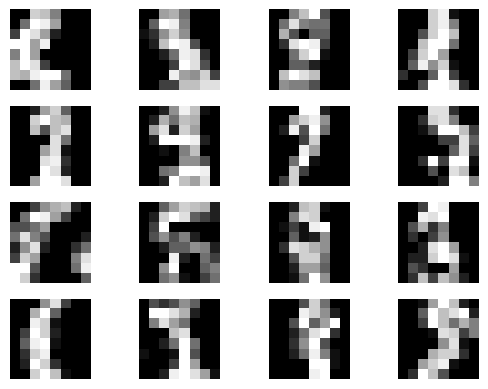

Epoch: 2, val nll=91.16495884486608
Epoch: 3, val nll=90.58173409598214
saved!


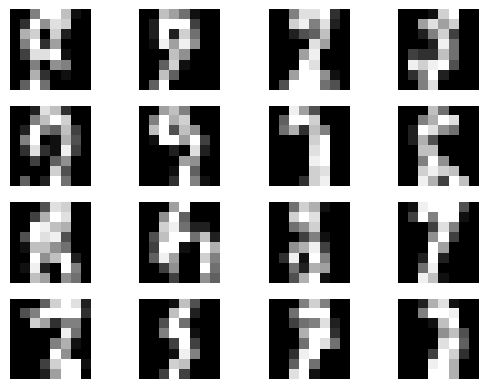

Epoch: 4, val nll=90.55865583147322
saved!


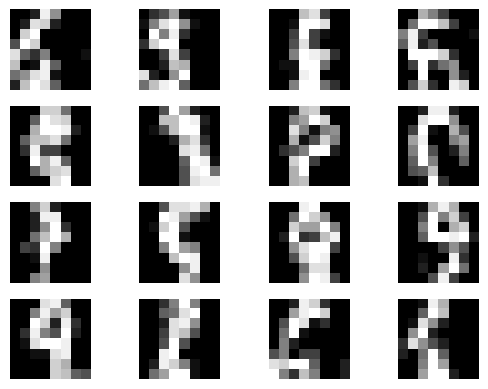

Epoch: 5, val nll=90.30377232142857
saved!


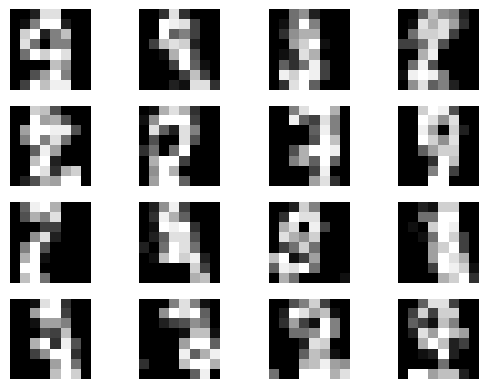

Epoch: 6, val nll=90.44430594308035
Epoch: 7, val nll=90.10510532924107
saved!


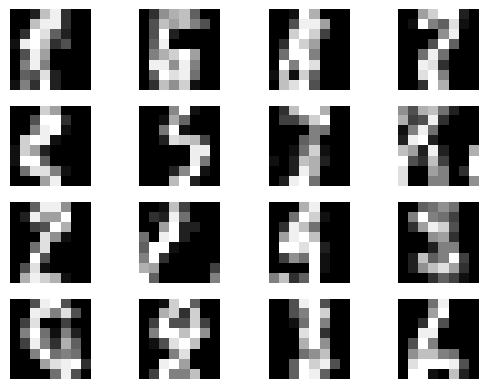

Epoch: 8, val nll=90.36439662388393
Epoch: 9, val nll=89.97392717633929
saved!


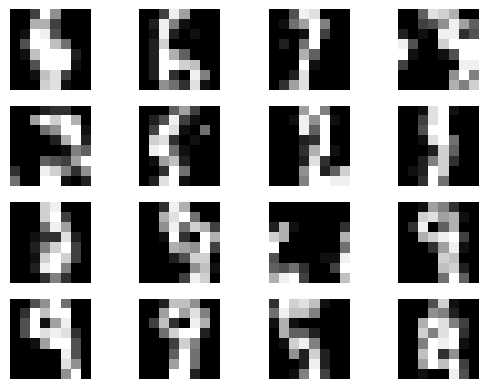

Epoch: 10, val nll=90.03626813616071
Epoch: 11, val nll=89.89002232142857
saved!


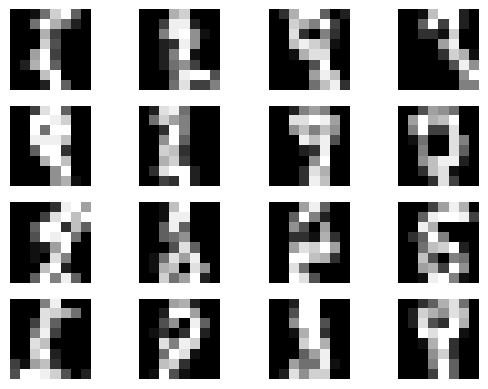

Epoch: 12, val nll=89.68461356026786
saved!


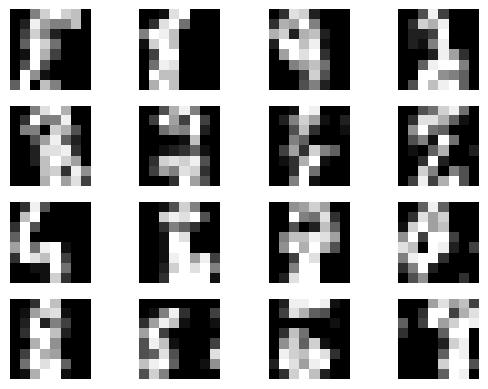

Epoch: 13, val nll=89.23405552455357
saved!


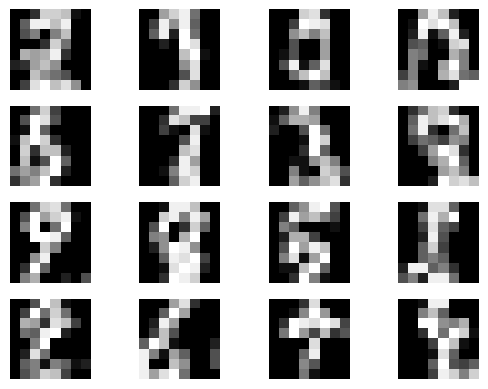

Epoch: 14, val nll=89.70744838169642
Epoch: 15, val nll=89.78251534598215
Epoch: 16, val nll=89.56290108816964
Epoch: 17, val nll=89.57217424665178
Epoch: 18, val nll=89.39121930803572
Epoch: 19, val nll=89.40428850446429
Epoch: 20, val nll=89.13691685267857
saved!


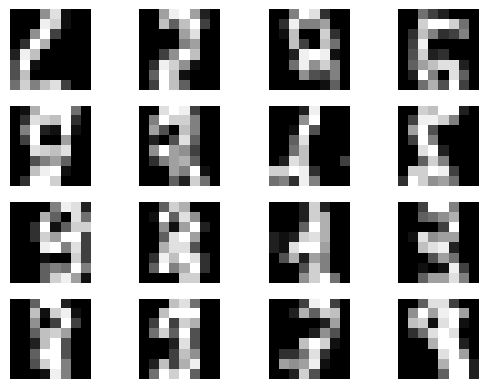

Epoch: 21, val nll=89.31159109933036
Epoch: 22, val nll=89.07431919642858
saved!


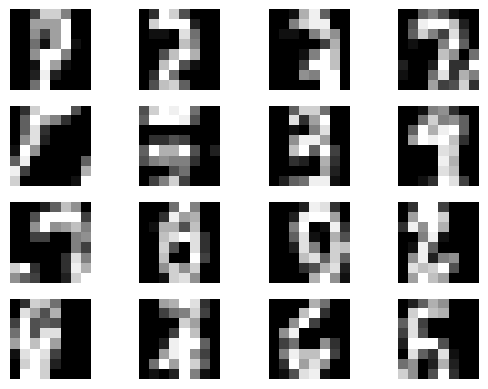

Epoch: 23, val nll=89.88260532924107
Epoch: 24, val nll=89.44556361607142
Epoch: 25, val nll=89.26276157924107
Epoch: 26, val nll=89.56368582589286
Epoch: 27, val nll=89.80799874441965
Epoch: 28, val nll=89.60318359375
Epoch: 29, val nll=89.239501953125
Epoch: 30, val nll=89.59941266741072
Epoch: 31, val nll=89.43528041294643
Epoch: 32, val nll=89.5353564453125
Epoch: 33, val nll=89.67146065848215
Epoch: 34, val nll=89.88411551339286
Epoch: 35, val nll=89.7187646484375
Epoch: 36, val nll=89.68697963169643
Epoch: 37, val nll=90.31395926339286
Epoch: 38, val nll=89.86369210379465
Epoch: 39, val nll=89.81556222098214
Epoch: 40, val nll=90.8392626953125
Epoch: 41, val nll=89.95707310267858
Epoch: 42, val nll=90.02323590959821
Epoch: 43, val nll=90.27347795758928


In [68]:
# Training procedure
nll_val = training(name= name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

In [69]:
test_loss = evaluation(name=name, test_loader=test_loader)
test_loss

FINAL LOSS: nll=86.7862715411773


86.7862715411773

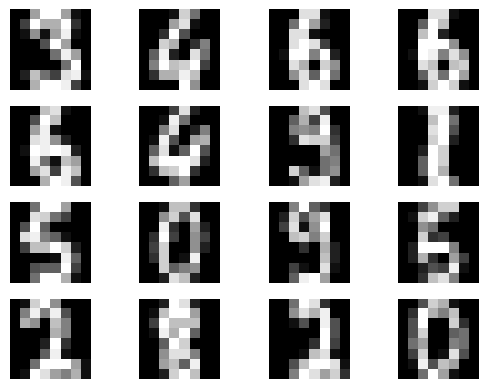

In [70]:
samples_real(name, test_loader)

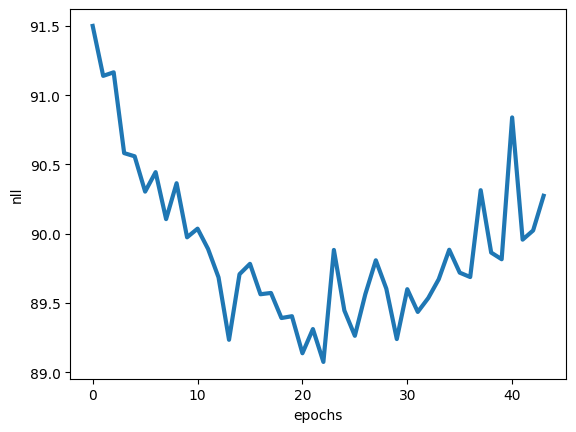

In [71]:
plot_curve(name, nll_val)